# Plot for Lucy 6/9/18

Challenge:

Make figures 7-12 of paper https://www.overleaf.com/15154648wznpkvkvxtzn

Provided galaxies:

file name | rotation | pixel size
-|-|-
agc4109natural_kmh20kms.edit4_mom0.fits | 82.83 | 1.7
9244_CLN_V2_0.edit3_mom0.fits | 39.01 | 2
agc6871all_natural_kmh20kms.edit3_mom0.fits | 33.74 | 1.4
9362_CLN_V2_4.edit1_mom0.fits | 64.5 | 2
8408_CLN_V2_0.edit1_mom0.fits | -37.45 | 2
B10_ALL_NAT.APCLN.edit6_mom0.fits | 40.42 | 1.7

Credit to Lucy Newnham for the original code, which I have modified.


Setting up our environment:

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
from astropy.io import fits
from scipy.ndimage import interpolation as ipt

In [2]:
df = pd.DataFrame.from_dict({
    'file name': [
        'agc4109natural_kmh20kms.edit4_mom0.fits',
        '9244_CLN_V2_0.edit3_mom0.fits',
        'agc6871all_natural_kmh20kms.edit3_mom0.fits',
        '9362_CLN_V2_4.edit1_mom0.fits',
        '8408_CLN_V2_0.edit1_mom0.fits',
        'B10_ALL_NAT.APCLN.edit6_mom0.fits',
    ],
    'rotation': [82.83, 39.01, 33.74, 64.5, -37.45, 40.42],
    'pixel size': [1.7, 2, 1.4, 2, 2, 1.7],
    'centerOffsetX': [0, 0, 0, 0, 0, 0.],
    'centerOffsetY': [0, 0, 0, 0, 0, -15.88],
})
df

,centerOffsetX,centerOffsetY,file name,pixel size,rotation
0,0.0,0.00,agc4109natural_kmh20kms.edit4_mom0.fits,1.7,82.83
1,0.0,0.00,9244_CLN_V2_0.edit3_mom0.fits,2.0,39.01
2,0.0,0.00,agc6871all_natural_kmh20kms.edit3_mom0.fits,1.4,33.74
3,0.0,0.00,9362_CLN_V2_4.edit1_mom0.fits,2.0,64.50
4,0.0,0.00,8408_CLN_V2_0.edit1_mom0.fits,2.0,-37.45
5,0.0,-15.88,B10_ALL_NAT.APCLN.edit6_mom0.fits,1.7,40.42


Little helper function:

In [3]:
toRad = lambda angle: np.pi * angle / 180

Test run for the first galaxy for styling choices

In [4]:
galaxy = df.iloc[0]

# Open the FITS file
hIFits = fits.open(galaxy['file name'])
data = hIFits[0].data

# data = np.zeros(data.shape) + np.arange(data.shape[0])

# Find the center point of the image in pixel coordinates
offset = np.array([galaxy['centerOffsetX'], galaxy['centerOffsetY']])
center = np.array(data.shape) / 2
center = (center + offset).astype(int)

# Make use of scipy to rotate the array about its center
hIRotated = ipt.rotate(data, galaxy['rotation'])

# define a rotation matrix
rotationMatrix = [
    [np.cos(toRad(galaxy['rotation'])), -np.sin(toRad(galaxy['rotation']))],
    [np.sin(toRad(galaxy['rotation'])), np.cos(toRad(galaxy['rotation']))]
]

# Find the center of the galaxy in the new array (pixel coordinates)
rotatedOffset = np.dot(rotationMatrix, offset)
rotatedCenter = np.array(hIRotated.shape) / 2 
rotatedCenter += rotatedOffset

# Calculate our array of summed values of the center cutout (row then column)
barRegion = hIRotated[int(rotatedCenter[1]-1):int(rotatedCenter[1]+2), :].T
middle = np.add.reduce(
    barRegion,
    axis=1
)

And now onto the plotting part of the code!

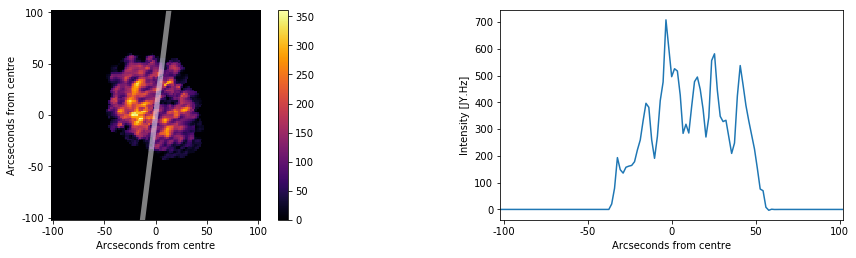

In [5]:
# Choose the cropping we want
n = 60
lowerCrop = (center - n).astype(int)
upperCrop = (center + n).astype(int)

rotatedLowerCrop = (rotatedCenter - n).astype(int)
rotatedUpperCrop = (rotatedCenter + n).astype(int)

# create a new figure
fig = plt.figure(figsize=(14, 8))

# working on the first panel
plt.subplot(221)
ax = plt.gca()

# show the rotated HI data
im = plt.imshow(data, origin='lower', cmap='inferno')

# Add a rectangle to represent center region, in the correct orientation
rectangleOrigin = np.array([0, center[1]-1.5])

r = Rectangle(
    np.dot(rotationMatrix, rectangleOrigin - center) + center,
    hIRotated.shape[1],
    3,
    alpha=0.5, fc='w',
    angle=galaxy['rotation']
)
ax.add_artist(r)

# Choose the x-ticks we want to display (every 50 arcseconds)
xticks = np.arange(-500, 500, 50)
# figure out where they should be positioned and place them
ax.set_xticks(xticks / galaxy['pixel size'] + center[0])
# set the labels
ax.set_xticklabels(xticks)

# same as above for y-axis
yticks = np.arange(-500, 500, 50)
ax.set_yticks(yticks / galaxy['pixel size'] + center[1])
ax.set_yticklabels(yticks)

# axis labels
ax.set_xlabel('Arcseconds from centre')
ax.set_ylabel('Arcseconds from centre')

# setting limits to crop our image
ax.set_xlim(lowerCrop[0], upperCrop[0])
ax.set_ylim(lowerCrop[1], upperCrop[1])

# adjust the positioning so we can fit the colorbar in
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.5)

# add the colorbar axes
plt.colorbar()

# Now for the second panel
plt.subplot(222)
ax = plt.gca()

# Plot the array we've calculated
ax.plot(middle)

# Set the xticks
ax.set_xticks(xticks / galaxy['pixel size'] + rotatedCenter[1])
ax.set_xticklabels(xticks)

# Set the limit
ax.set_xlim(rotatedLowerCrop[1], rotatedUpperCrop[1])

# And axis label!
ax.set_xlabel('Arcseconds from centre')
ax.set_ylabel('Intensity [JY.Hz]')

# Save the output
plt.savefig('example.png', bbox_inches='tight')

Now we have the styling sorted, let's apply it to all the galaxies, on an A4 sized image:

In [6]:
matplotlib.rcParams.update({'font.size': 8})

In [7]:
def makeGalaxyObject(galaxy):
    # Open the FITS file
    hIFits = fits.open(galaxy['file name'])
    data = hIFits[0].data

    # data = np.zeros(data.shape) + np.arange(data.shape[0])

    # Find the center point of the image in pixel coordinates
    offset = np.array([galaxy['centerOffsetX'], galaxy['centerOffsetY']])
    center = np.array(data.shape) / 2
    center = (center + offset).astype(int)

    # Make use of scipy to rotate the array about its center
    hIRotated = ipt.rotate(data, galaxy['rotation'])

    # define a rotation matrix
    rotationMatrix = [
        [np.cos(toRad(galaxy['rotation'])), -np.sin(toRad(galaxy['rotation']))],
        [np.sin(toRad(galaxy['rotation'])), np.cos(toRad(galaxy['rotation']))]
    ]

    # Find the center of the galaxy in the new array (pixel coordinates)
    rotatedOffset = np.dot(rotationMatrix, offset)
    rotatedCenter = np.array(hIRotated.shape) / 2 
    rotatedCenter += rotatedOffset

    # Calculate our array of summed values of the center cutout (row then column)
    barRegion = hIRotated[int(rotatedCenter[1]-1):int(rotatedCenter[1]+2), :].T
    middle = np.add.reduce(
        barRegion,
        axis=1
    )
    return {
        'file name': galaxy['file name'],
        'pixel size': galaxy['pixel size'],
        'rotation': galaxy['rotation'],
        'rotation matrix': rotationMatrix,
        'hIFits': hIFits,
        'hIRotated': hIRotated,
        'center': center,
        'rotatedCenter': rotatedCenter,
        'middle': middle,
    }

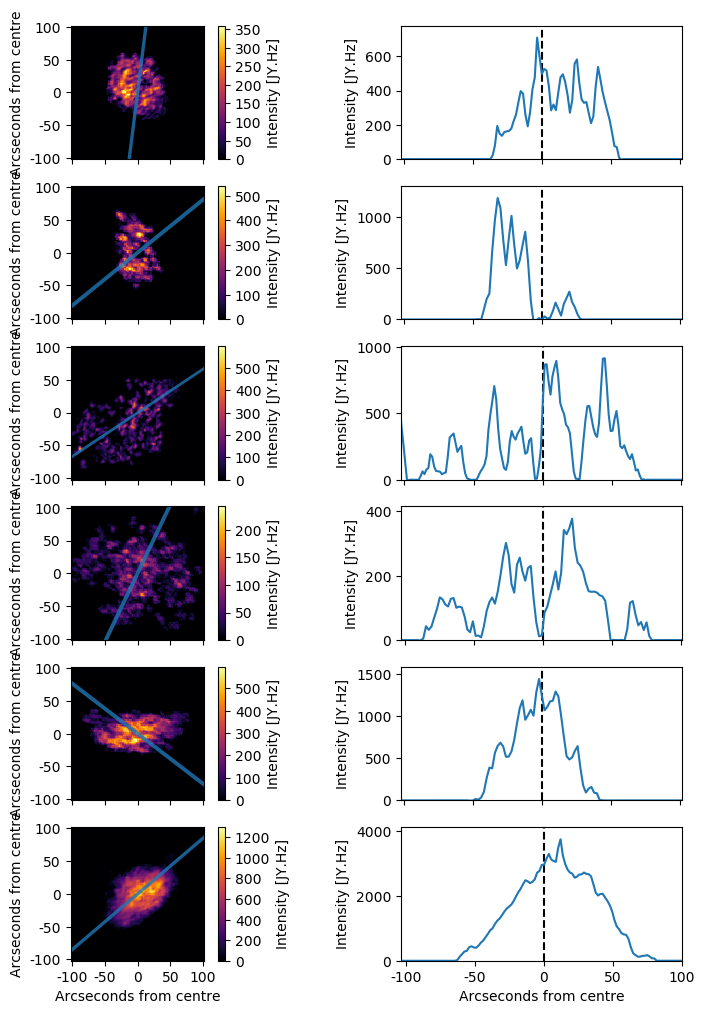

In [18]:
fig = plt.figure(figsize=(8.27, 11.69), dpi=100)
n = 60
for rowIndex in range(len(df)):
    galaxy = makeGalaxyObject(df.iloc[rowIndex])
    n = 60 * 1.7 / galaxy['pixel size']
    # Choose the cropping we want
    lowerCrop = (galaxy['center'] - n).astype(int)
    upperCrop = (galaxy['center'] + n).astype(int)

    rotatedLowerCrop = (galaxy['rotatedCenter'] - n).astype(int)
    rotatedUpperCrop = (galaxy['rotatedCenter'] + n).astype(int)

    # working on the first panel
    plt.subplot(len(df), 2, rowIndex*2 + 1)
    ax = plt.gca()

    # show the rotated HI data
    im = plt.imshow(
        galaxy['hIFits'][0].data,
        origin='lower',
        cmap='inferno'
    )

    # Add a rectangle to represent center region, in the correct orientation
    rectangleOrigin = np.array([0, galaxy['center'][1]-1.5])
    rotationMatrix = galaxy['rotation matrix']
    r = Rectangle(
        np.dot(
            rotationMatrix, 
            rectangleOrigin - galaxy['center']
        ) + galaxy['center'],
        galaxy['hIRotated'].shape[1],
        3,
        alpha=0.8,
        angle=galaxy['rotation']
    )
    ax.add_artist(r)

    # Choose the x-ticks we want to display (every 50 arcseconds)
    xticks = np.arange(-500, 500, 50)
    # figure out where they should be positioned and place them
    ax.set_xticks(xticks / galaxy['pixel size'] + galaxy['center'][0])
    # set the labels
    ax.set_xticklabels(xticks)

    # same as above for y-axis
    yticks = np.arange(-500, 500, 50)
    ax.set_yticks(yticks / galaxy['pixel size'] + galaxy['center'][1])
    ax.set_yticklabels(yticks)

    # axis labels
    if rowIndex == len(df) - 1:
        ax.set_xlabel('Arcseconds from centre')
    else:
        plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_ylabel('Arcseconds from centre')

    # setting limits to crop our image
    ax.set_xlim(lowerCrop[0], upperCrop[0])
    ax.set_ylim(lowerCrop[1], upperCrop[1])

    # adjust the positioning so we can fit the colorbar in
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.9, wspace=0.5)

    # add the colorbar axes
    cbar = plt.colorbar()
    cbar.set_label('Intensity [JY.Hz]')

    # Now for the second panel
    plt.subplot(len(df), 2, rowIndex*2 + 2)
    ax = plt.gca()
    
    # add a central dashed line
    ax.add_line(Line2D(
        [galaxy['rotatedCenter'][1]] * 2, [0, 100000],
        linestyle='--',
        c='k',
    ))

    # Plot the array we've calculated
    ax.plot(galaxy['middle'])
        
    # Set the xticks
    ax.set_xticks(xticks / galaxy['pixel size'] + galaxy['rotatedCenter'][1])
    ax.set_xticklabels(xticks)

    # Set the limit
    ax.set_xlim(rotatedLowerCrop[1], rotatedUpperCrop[1])
    ax.set_ylim(0, np.max(galaxy['middle'])*1.1)

    # And axis label!
    ax.set_ylabel('Intensity [JY.Hz]')
    
    if rowIndex == len(df) - 1:
        ax.set_xlabel('Arcseconds from centre')
    else:
        plt.setp(ax.get_xticklabels(), visible=False)

# Save the output
plt.savefig('mosaic.png', bbox_inches='tight')